In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs6353/assignments/assignment2/'
FOLDERNAME = 'CS6353/Assignments/assignment2/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs6353/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Install requirements from colab_requirements.txt
# TODO: Please change your path below to the colab_requirements.txt file
! python -m pip install -r /content/drive/My\ Drive/$FOLDERNAME/colab_requirements.txt

Mounted at /content/drive
/content/drive/My Drive/CS6353/Assignments/assignment2/assignment2/cs6353/datasets
--2024-09-29 20:45:04--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  40.6MB/s    in 4.2s    

2024-09-29 20:45:08 (38.6 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content/drive/My Drive/CS6353/Assignments/assignment2/assignment2
     ━━━━━━━

# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://utah.instructure.com/courses/919972/assignments/12590082) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
from __future__ import print_function
import random
import numpy as np
from cs6353.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs6353/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs6353/classifiers/softmax.py**.


In [ ]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs6353/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs6353.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.372274
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** We expect the initial loss to be close to -log(0.1) because, at the start, before any learning has occurred, the weights are randomly initialized. This randomness means the model has no prior knowledge, so it treats all classes as equally likely. Since CIFAR-10 has ten possible classes, the probability assigned to each class is 1 / 10 = 0.1. The softmax loss is calculated as the negative log of the probability assigned to the correct class. Therefore, with all classes equally probable, the initial loss will approximate -log(0.1). Note: Weights are initialized as small random values to break symmetry between neurons, therby ensuring diverse feature learning, and prevent issues like vanishing or exploding gradients and stabilizing the training process.


In [ ]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs6353.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.371995 analytic: -0.371995, relative error: 9.412997e-08
numerical: 0.061519 analytic: 0.061519, relative error: 3.447618e-07
numerical: 0.015320 analytic: 0.015319, relative error: 3.233951e-06
numerical: -3.687516 analytic: -3.687516, relative error: 1.263554e-08
numerical: 0.483787 analytic: 0.483787, relative error: 2.404416e-08
numerical: 2.102420 analytic: 2.102420, relative error: 3.515781e-08
numerical: 0.204487 analytic: 0.204487, relative error: 3.160889e-08
numerical: 0.191245 analytic: 0.191245, relative error: 1.395001e-07
numerical: 1.774520 analytic: 1.774520, relative error: 6.925438e-09
numerical: 1.360575 analytic: 1.360575, relative error: 1.581803e-08
numerical: 0.061908 analytic: 0.061908, relative error: 1.201088e-06
numerical: -1.212397 analytic: -1.212397, relative error: 4.147778e-10
numerical: -2.129776 analytic: -2.129776, relative error: 3.312535e-09
numerical: -1.419020 analytic: -1.419020, relative error: 2.004402e-08
numerical: -0.530724 ana

In [ ]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs6353.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.372274e+00 computed in 0.079418s
vectorized loss: 2.372274e+00 computed in 0.009491s
Loss difference: 0.000000
Gradient difference: 0.000000


In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs6353.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7, 2e-6, 1e-5]
regularization_strengths = [2.5e4, 5e4, 1e3, 5e3, 5e2]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifier in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:

        softmax = Softmax()

        softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=True)

        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)

        train_results = y_train_pred == y_train
        y_train_accuracy = np.mean(train_results)

        val_results = y_val_pred == y_val
        y_val_accuracy = np.mean(val_results)

        results[(lr, reg)] = (y_train_accuracy, y_val_accuracy)

        if y_val_accuracy > best_val:
            best_val = y_val_accuracy
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 773.286769
iteration 100 / 1500: loss 283.934386
iteration 200 / 1500: loss 105.170970
iteration 300 / 1500: loss 39.787913
iteration 400 / 1500: loss 15.907862
iteration 500 / 1500: loss 7.166709
iteration 600 / 1500: loss 3.905783
iteration 700 / 1500: loss 2.791000
iteration 800 / 1500: loss 2.311611
iteration 900 / 1500: loss 2.217738
iteration 1000 / 1500: loss 2.140678
iteration 1100 / 1500: loss 2.090252
iteration 1200 / 1500: loss 2.083181
iteration 1300 / 1500: loss 2.053110
iteration 1400 / 1500: loss 2.066172
iteration 0 / 1500: loss 1543.696962
iteration 100 / 1500: loss 207.893923
iteration 200 / 1500: loss 29.661242
iteration 300 / 1500: loss 5.796347
iteration 400 / 1500: loss 2.656400
iteration 500 / 1500: loss 2.273789
iteration 600 / 1500: loss 2.124694
iteration 700 / 1500: loss 2.139541
iteration 800 / 1500: loss 2.106462
iteration 900 / 1500: loss 2.160759
iteration 1000 / 1500: loss 2.132417
iteration 1100 / 1500: loss 2.215994
iteration 1

In [ ]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.378000


**Inline Question** - *True or False*

It's possible to add a new data point to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: True.

*Your explanation*: In the case of an SVM loss, a new data point can have a margin that is already satisfied (i.e., the correct class score is sufficiently higher than the incorrect class scores by a margin), which would result in zero additional loss. In contrast, the Softmax classifier loss is based on probabilities, and every new data point contributes to the total probability distribution, so adding a new data point will always change the loss, even if it's a small change.

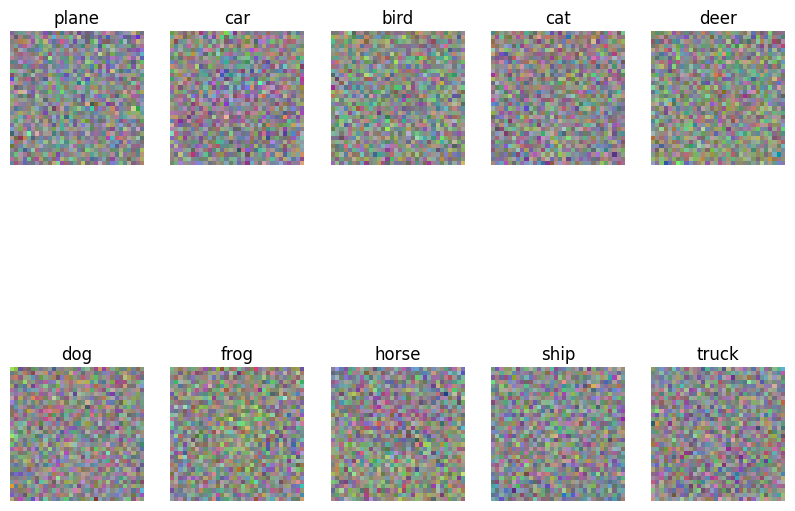

In [ ]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])